## Config and others

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import torch
from torch.utils.data import Dataset
import sys
import pathlib
from collections import Counter
from typing import Callable
import jieba  
import codecs 
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

In [ ]:
# check if GPU is being used
# return True if GPU is being used
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed Jul 20 09:46:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class config:
  # General
  hidden_size: int = 256
  dec_hidden_size: Optional[int] = 256
  embed_size: int = 256

  # Data
  max_vocab_size = 50000
  embed_file: Optional[str] = None  # use pre-trained embeddings

  # working directory
  root_path = os.path.abspath(os.path.dirname('/content/drive/MyDrive/GU/580/Data/'))
  os.chdir(root_path)

  data_path = os.path.join(root_path, 'data_pairs.txt')
  train_data_path = os.path.join(root_path, 'train.txt')
  val_data_path: Optional[str] = os.path.join(root_path, 'dev.txt')
  test_data_path: Optional[str] = os.path.join(root_path, 'test.txt')
  stop_word_file = os.path.join(root_path, 'HIT_stop_words.txt')

  max_src_len: int = 300  # exclusive of special tokens such as EOS
  max_tgt_len: int = 100  # exclusive of special tokens such as EOS
  truncate_src: bool = True
  truncate_tgt: bool = True
  min_dec_steps: int = 20
  max_dec_steps: int = 50
  enc_rnn_dropout: float = 0.5
  enc_attn: bool = True
  dec_attn: bool = True
  dec_in_dropout = 0.2
  dec_rnn_dropout = 0.2
  dec_out_dropout = 0.2


  # Training
  trunc_norm_init_std = 1e-4
  eps = 1e-31
  learning_rate = 0.001
  lr_decay = 0.0
  initial_accumulator_value = 0.1
  epochs = 4
  batch_size = 6

  pointer = False
  coverage = True
  #fine_tune = False
  scheduled_sampling = False # Teacher forcing
  weight_tying = False
  max_grad_norm = 2.0
  is_cuda = True
  DEVICE = torch.device("cuda" if is_cuda else "cpu")
  LAMBDA = 1


  # Beam search
  beam_size: int = 3
  alpha = 0.2
  beta = 0.2
  gamma = 2000

  # Model save path
  model_name = 'baseline'
  if pointer:
    model_name = 'pgn'
  model_name += '_' + str(hidden_size)
  if coverage:
    model_name += '_cov'
  if scheduled_sampling:
    model_name += '_teacher'

  #调用系统命令行来创建文件夹
  directory_path = os.path.join(root_path, 'model_save/' + model_name + '/')
  if not os.path.exists(directory_path):
    os.makedirs(directory_path)

  encoder_save_name = os.path.join(root_path, 'model_save/' + model_name + '/encoder.pt')
  decoder_save_name = os.path.join(root_path, 'model_save/' + model_name + '/decoder.pt')
  attention_save_name = os.path.join(root_path, 'model_save/' + model_name + '/attention.pt')
  reduce_state_save_name = os.path.join(root_path, 'model_save/' + model_name + '/reduce_state.pt')
  losses_path = os.path.join(root_path, 'model_save/' + model_name + '/validation_loss.pkl')

In [ ]:
config.model_name

'baseline_256_cov'

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.0 MB/s 


In [ ]:
!pip install import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Processing

## Vocab dictionary

<p> In nlp task, we need to first tokenize our texts into each token, then turn each token into some number index that can be read by the model. We use vocab dictionary to turn token into number index.

In [ ]:
from collections import Counter

class Vocab:
  # assign initial index to pad, sos(indicate the start of sequence), eos(indicate the end of sequence) and unk (unknown token)
  PAD = 0
  SOS = 1
  EOS = 2
  UNK = 3

  def __init__(self):
    self.word2index = {}
    self.word2count = Counter()
    self.index2word = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']

  def addWord(self, words):
    """add new token to vocab and map word to index
    """
    for word in words:
      if word not in self.word2index:
        self.word2index[word] = len(self.index2word)
        self.index2word.append(word)
    self.word2count.update(words)
  
  def __len__(self):
    return len(self.index2word)

  def __getitem__(self, item):
    if type(item) is int:
      return self.index2word[item]
    return self.word2index.get(item, self.UNK)

  def size(self):
    """Returns the total size of the vocabulary
    """
    return len(self.index2word)


In [ ]:
def count_words(counter, text):
    '''
    Count the number of occurrences of each word in a set of text
    '''
    for sentence in text:
        for word in sentence:
            counter[word] += 1

## DataSet

In [ ]:
class PairDataset:
  """create src-tgt pairs dataset for model.
  """
  def __init__(self, filename):
      self.filename = filename
      self.pairs = []
      
      with open(filename, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
        # split the source and target by the <sep> tag.
          pair = line.strip().split('<sep>')
          # split lines to tokens in src and tgt
          src = pair[1].split()
          tgt = pair[2].split()
          self.pairs.append((src, tgt))
      print("%d pairs." % len(self.pairs))
          
  def build_vocab(self, embed_file: str = None) -> Vocab:
    # count word frequency in src-tgt pairs
    word_counts = Counter()
    text = [src + tgt for src, tgt in self.pairs]
    for sentence in text:
      for token in sentence:
        word_counts[token] += 1

    # create word to index with the most frequent words having smaller index
    vocab = Vocab()
    for word, count in word_counts.most_common(config.max_vocab_size):
        vocab.addWord([word])
    #if embed_file is not None:
        #count = vocab.load_embeddings(embed_file)
        #print("%d pre-trained embeddings loaded." % count)

    return vocab

In [ ]:
# 代码调试
# pairs = []
# filename = os.path.join(abs_path, 'dev.txt')
# with open(filename, 'rt', encoding='utf-8') as f:
#   for i, line in enumerate(f):
#   # split the source and target by the <sep> tag.
#     pair = line.strip().split('<sep>')
#     if len(pair) != 2:
#       continue
#     # split lines to tokens in src and tgt
#     src = pair[0].split()
#     tgt = pair[1].split()
#     pairs.append((src, tgt))

In [ ]:
# word_counts = Counter()
# text = [src + tgt for src, tgt in pairs]
# for sentence in text:
#   for token in sentence:
#     word_counts[token] += 1
# print(word_counts)

In [ ]:
# vocab = Vocab()
# for word, count in word_counts.most_common(20000):
#     vocab.addWord([word])
# print(vocab.word2index.items())

In [ ]:
def src2ids(src_list, vocab):
  # oov: out of vocabulary
  ids = []
  oovs = []
  unk_id = vocab.UNK
  for w in src_list:
    i = vocab[w]
    if i == unk_id:
      if w not in oovs:
        oovs.append(w)
      oov_num = oovs.index(w)
      #print('oov_num is :', oov_num)
      ids.append(vocab.size() + oov_num)
    else:
      ids.append(i)
  return ids, oovs

In [ ]:
def tgt2ids(tgt_list, vocab, src_oov):
  ids = []
  unk_id = vocab.UNK
  for w in tgt_list:
    i = vocab[w]
    if i == unk_id:
      if w in src_oov:
        vocab_idx = vocab.size() + src_oov.index(w)
        ids.append(vocab_idx)
      else:
        ids.append(unk_id)
    else:
      ids.append(i)
  return ids

In [ ]:
#代码调试
# src_sentence = [x[0] for x in pairs]
# tgt_sentence = [x[1] for x in pairs]
# pair_len = len(pairs)
# idx, oov = src2ids(src_sentence[2], vocab)
# print(oov)

In [ ]:
# print(src_sentence[2])

In [ ]:
class SampleDataset(Dataset):
  """ sample dataset for training"""
  def __init__(self, data_pair, vocab):
    self.src_sentence = [x[0] for x in data_pair]
    self.tgt_sentence = [x[1] for x in data_pair]
    self.vocab = vocab
    # Keep track of how many data points.
    self._len = len(data_pair)

  def __getitem__(self, index):
    x, oov = src2ids(self.src_sentence[index], self.vocab)
    return {
        'x': [self.vocab.SOS] + x + [self.vocab.EOS],
        'OOV': oov,
        'len_OOV': len(oov),
        'y': [self.vocab.SOS] + tgt2ids(self.tgt_sentence[index], self.vocab, oov) + [self.vocab.EOS],
        'x_len': len(self.src_sentence[index]),
        'y_len': len(self.tgt_sentence[index])
        }

  def __len__(self):
    return self._len

In [ ]:
# 代码调试
# dataset = Dataset(pairs, vocab)
# dataset.__getitem__(2)

## Batch utils

In [ ]:
def sort_batch_by_len(data_batch):
  '''this function sort indices of data in batch by length'''
  res = {'x': [],
         'y': [],
          'x_len': [],
          'y_len': [],
          'OOV': [],
          'len_OOV': []}
  for i in range(len(data_batch)):
      res['x'].append(data_batch[i]['x'])
      res['y'].append(data_batch[i]['y'])
      res['x_len'].append(len(data_batch[i]['x']))
      res['y_len'].append(len(data_batch[i]['y']))
      res['OOV'].append(data_batch[i]['OOV'])
      res['len_OOV'].append(data_batch[i]['len_OOV'])

  sorted_indices = np.array(res['x_len']).argsort()[::-1].tolist()

  data_batch = {
      name: [_tensor[i] for i in sorted_indices]
      for name, _tensor in res.items()
  }
  return data_batch

In [ ]:
def collate_fn(batch):
  '''this function turn input data batch to padded data batch'''
  def padding(indice, max_length, pad_idx=0):
    '''this function add padding to sentence based on the max length of sentences from the same batch'''
    pad_indice = [item + [pad_idx] * max(0, max_length - len(item)) for item in indice]
    return torch.tensor(pad_indice)

  data_batch = sort_batch_by_len(batch)
  x = data_batch["x"]
  x_max_length = max([len(t) for t in x])
  y = data_batch["y"]
  y_max_length = max([len(t) for t in y])

  OOV = data_batch["OOV"]
  len_OOV = torch.tensor(data_batch["len_OOV"])

  x_padded = padding(x, x_max_length)
  y_padded = padding(y, y_max_length)

  x_len = torch.tensor(data_batch["x_len"])
  y_len = torch.tensor(data_batch["y_len"])
  return x_padded, y_padded, x_len, y_len, OOV, len_OOV

## Data utils

In [ ]:
def outputids2words(id_list, source_oovs, vocab):
    """
        Maps output ids to words.
    """
    words = []
    for i in id_list:
        try:
            w = vocab.index2word[i]  # might be [UNK]
        except IndexError:  # w is OOV
            assert_msg = "Error: cannot find the ID the in the vocabulary."
            assert source_oovs is not None, assert_msg
            source_oov_idx = i - vocab.size()
            try:
                w = source_oovs[source_oov_idx]
            except ValueError:  # i doesn't correspond to an source oov
                raise ValueError(
                    'Error: model produced word ID %i corresponding to source OOV %i \
                     but this example only has %i source OOVs'
                    % (i, source_oov_idx, len(source_oovs)))
        words.append(w)
    return ' '.join(words)

In [ ]:
def replace_oovs(in_tensor, vocab):
    """Replace oov tokens in a tensor with the <UNK> token.
    """    
    oov_token = torch.full(in_tensor.shape, vocab.UNK).long().to(config.DEVICE)
    out_tensor = torch.where(in_tensor > len(vocab) - 1, oov_token, in_tensor)
    return out_tensor

In [ ]:
import time
def timer(module):
    def wrapper(func):
        def cal_time(*args, **kwargs):
            t1 = time.time()
            res = func(*args, **kwargs)
            t2 = time.time()
            cost_time = t2 - t1
            print(f'{cost_time} secs used for ', module)
            return res
        return cal_time
    return wrapper

# Model Construction

## Model (Seq2Seq + Attention)
* Encoder: Embedding + BiLSTM + Softmax
* Attention: Feed Forward + Softmax
* Decoder: Embedding + LSTM + Feed Forward + Softmax


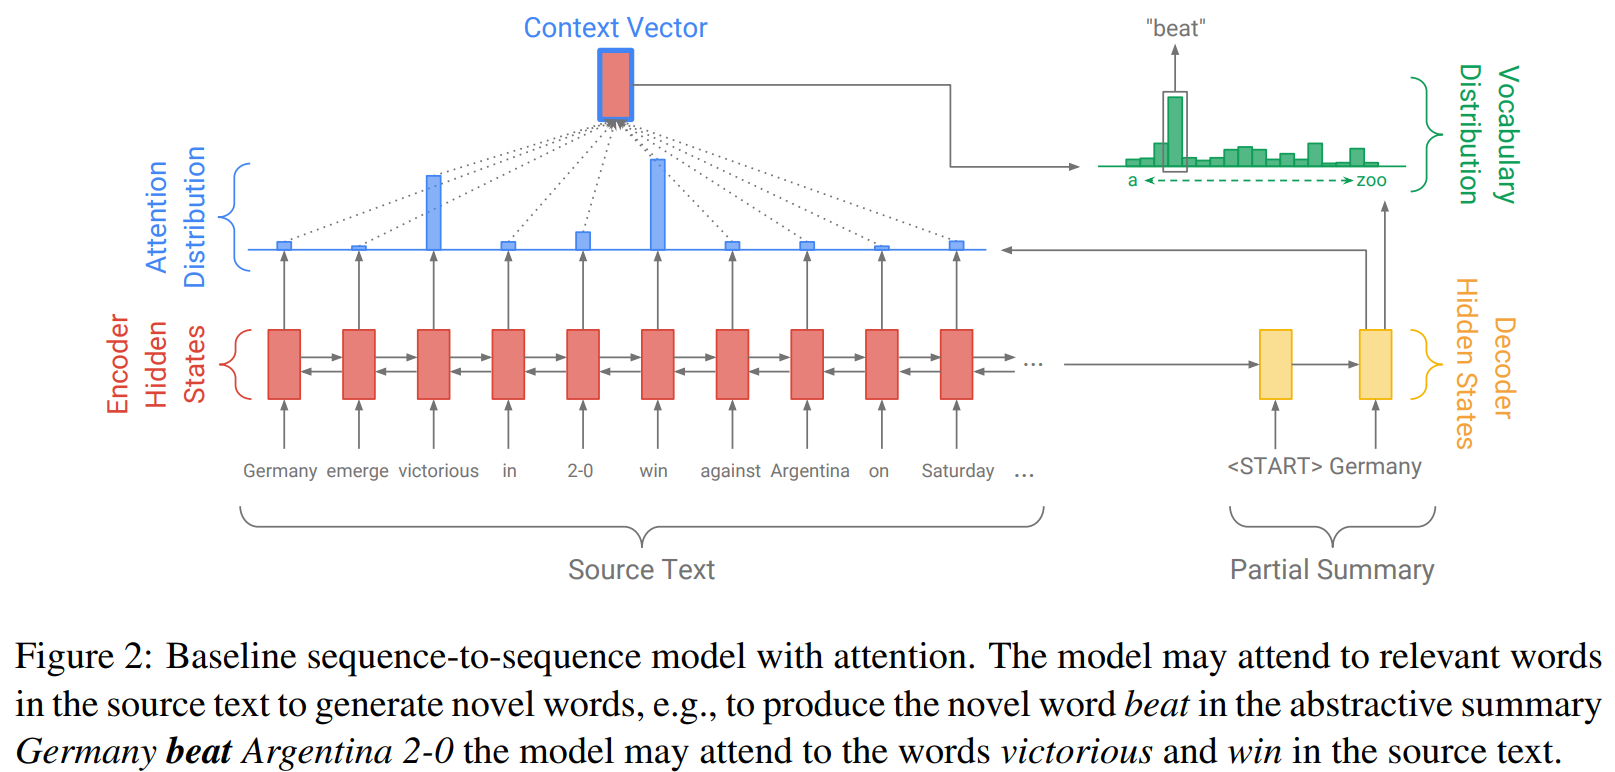

In [ ]:
class Encoder(nn.Module):
  """encoder part of Seq2Seq model"""
  def __init__(self, vocab_size, embed_size, hidden_size, rnn_drop: float = 0):
    super(Encoder, self).__init__()

    # embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.hidden_size = hidden_size

    # define bidirectional lstm
    self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, dropout=rnn_drop, batch_first=True)

    # since bidirectiona is true, the dimension of output will double
    #self.fc = nn.Linear(hidden_size * 2, dec_hidden_size)

  def forward(self, x):
    """forward propagation for encoder"""
    embedded = self.embedding(x)
    output, hidden = self.lstm(embedded)
    return output, hidden

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, enc_hidden_size=None, is_cuda=True):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.DEVICE = torch.device('cuda') if is_cuda else torch.device('cpu')
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.W1 = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.W2 = nn.Linear(self.hidden_size, vocab_size)
        
    def forward(self, x_t, decoder_states, context_vector):
        """Define forward propagation for the decoder.
        """
        decoder_emb = self.embedding(x_t)
        decoder_output, decoder_states = self.lstm(decoder_emb, decoder_states)

        # concatenate context vector and decoder state
        decoder_output = decoder_output.view(-1, config.hidden_size)
        concat_vector = torch.cat([decoder_output, context_vector], dim=-1)

        # calculate vocabulary distribution
        # (batch_size, hidden_units)
        FF1_out = self.W1(concat_vector)
        # (batch_size, vocab_size)
        FF2_out = self.W2(FF1_out)
        # (batch_size, vocab_size)
        p_vocab = F.softmax(FF2_out, dim=1)
        # Concatenate h and c to get s_t and expand the dim of s_t.
        h_dec, c_dec = decoder_states
        # (1, batch_size, 2*hidden_units)
        s_t = torch.cat([h_dec, c_dec], dim=2)

        return p_vocab, decoder_states

In [ ]:
class Attention(nn.Module):
  """attention part"""
  def __init__(self, hidden_units):
    super(Attention, self).__init__()
    # Define feed-forward layers.
    self.Wh = nn.Linear(2*hidden_units, 2*hidden_units, bias=False)
    self.Ws = nn.Linear(2*hidden_units, 2*hidden_units)
    self.v = nn.Linear(2*hidden_units, 1, bias=False)

    #self.wc = nn.Linear(1, 2*hidden_units, bias=False)

  # def forward(self, decoder_states, encoder_output, x_padding_masks):
  def forward(self, decoder_states, encoder_output, x_padding_masks, coverage_vector):
    """Define forward propagation for the attention network.
    """
    # Concatenate h and c to get s_t and expand the dim of s_t.
    h_dec, c_dec = decoder_states
    # (1, batch_size, 2*hidden_units)
    s_t = torch.cat([h_dec, c_dec], dim=2)
    # (batch_size, 1, 2*hidden_units)
    s_t = s_t.transpose(0, 1)
    # (batch_size, seq_length, 2*hidden_units)
    s_t = s_t.expand_as(encoder_output).contiguous()

    # calculate attention scores
    # Wh h_* (batch_size, seq_length, 2*hidden_units)
    encoder_features = self.Wh(encoder_output.contiguous())
    # Ws s_t (batch_size, seq_length, 2*hidden_units)
    decoder_features = self.Ws(s_t)
    # (batch_size, seq_length, 2*hidden_units)
    att_inputs = encoder_features + decoder_features

    # (batch_size, seq_length, 1)
    score = self.v(torch.tanh(att_inputs))
    # (batch_size, seq_length)
    attention_weights = F.softmax(score, dim=1).squeeze(2)
    attention_weights = attention_weights * x_padding_masks
    # Normalize attention weights after excluding padded positions.
    normalization_factor = attention_weights.sum(1, keepdim=True)
    attention_weights = attention_weights / normalization_factor
    # (batch_size, 1, 2*hidden_units)
    context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_output)
    # (batch_size, 2*hidden_units)
    context_vector = context_vector.squeeze(1)
    

    # coverage
    coverage_vector = coverage_vector + attention_weights

    return context_vector, attention_weights, coverage_vector

In [ ]:
class ReduceState(nn.Module):
    """because we use BiLSTM in encoder, and LSTM in decoder, 
    when we use output from encoder as initialized hidden state for decoder, we need to reduce state for encoder
    """
    def __init__(self):
        super(ReduceState, self).__init__()

    def forward(self, hidden):
        """The forward propagation of reduce state module.
        """
        h, c = hidden
        h_reduced = torch.sum(h, dim=0, keepdim=True)
        c_reduced = torch.sum(c, dim=0, keepdim=True)
        return (h_reduced, c_reduced)

In [ ]:
class Seq2seq(nn.Module):
  def __init__(self, v):
    super(Seq2seq, self).__init__()
    self.v = v
    self.DEVICE = torch.device('cuda') if config.is_cuda else torch.device('cpu')
    self.attention = Attention(config.hidden_size)
    self.encoder = Encoder(len(v), config.embed_size, config.hidden_size,)
    self.decoder = Decoder(len(v), config.embed_size, config.hidden_size,)
    self.reduce_state = ReduceState()
  
  def forward(self, x, x_len, y, len_oovs, batch):
    x_copy = replace_oovs(x, self.v)
    x_padding_masks = torch.ne(x, 0).byte().float()
    encoder_output, encoder_states = self.encoder(x_copy)
    # Reduce encoder hidden states.
    decoder_states = self.reduce_state(encoder_states)

    # Initialize coverage vector.
    coverage_vector = torch.zeros(x.size()).to(self.DEVICE)

    # Calculate loss for every step.
    step_losses = []
    for t in range(y.shape[1]-1):
      # Do teacher forcing.
      x_t = y[:, t]
      x_t = replace_oovs(x_t, self.v)
      y_t = y[:, t+1]

      # Get context vector from the attention network.
      context_vector, attention_weights, coverage_vector = self.attention(
          decoder_states, encoder_output, x_padding_masks, coverage_vector
          )
      # Get vocab distribution and hidden states from the decoder.
      p_vocab, decoder_states= self.decoder(
          x_t.unsqueeze(1), decoder_states, context_vector
          )
      # Get the probabilities predict by the model for target tokens.
      y_t = replace_oovs(y_t, self.v)
      target_probs = torch.gather(p_vocab, 1, y_t.unsqueeze(1))
      target_probs = target_probs.squeeze(1)
      # Apply a mask such that pad zeros do not affect the loss
      mask = mask = torch.ne(y_t, 0).byte()
      # Do smoothing to prevent getting NaN loss because of log(0).
      loss = -torch.log(target_probs + config.eps)
      mask = mask.float()
      loss = loss * mask
      step_losses.append(loss)
    
    sample_losses = torch.sum(torch.stack(step_losses, 1), 1)
    # get the non-padded length of each sequence in the batch
    seq_len_mask = torch.ne(y, 0).byte().float()
    batch_seq_len = torch.sum(seq_len_mask, dim=1)
    # get batch loss by dividing the loss of each batch
    # by the target sequence length and mean
    batch_loss = torch.mean(sample_losses / batch_seq_len)
    return batch_loss

  def get_final_distribution(self, p_vocab):
    return p_vocab
  
  def load_model(self):
    """Load saved model if there exits one.
    """        
    if (os.path.exists(config.encoder_save_name)):
        self.encoder = torch.load(config.encoder_save_name)
        self.decoder = torch.load(config.decoder_save_name)
        self.attention = torch.load(config.attention_save_name)
        self.reduce_state = torch.load(config.reduce_state_save_name)

## Train

In [ ]:
import pickle
import os
import sys
import pathlib

import numpy as np
from torch import optim
from torch.utils.data import DataLoader
import torch
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from tensorboardX import SummaryWriter
import import_ipynb

In [ ]:
import random
class ScheduledSampler():
  def __init__(self, phases):
    self.phases = phases
    self.scheduled_probs = [i / (self.phases - 1) for i in range(self.phases)]
  
  def teacher_forcing(self, phase):
    """Teacher forcing is the technique where the target word is passed as the next input to the decoder. 
       Here the function chooses whether to execute teacher_forcing according to a certain probability.
    """
    sampling_prob = random.random()
    if sampling_prob >= self.scheduled_probs[phase]:
      return True
    else:
      return False

In [ ]:
def evaluate(model, val_data, epoch):
  print('validating')
  val_loss = []
  with torch.no_grad():
    DEVICE = torch.device('cuda') if config.is_cuda else torch.device('cpu')
    val_dataloader = DataLoader(
        dataset=val_data,
        batch_size=config.batch_size,
        shuffle=True,
        pin_memory=True, drop_last=True,
        collate_fn=collate_fn)
    for batch, data in enumerate(tqdm(val_dataloader)):
      x, y, x_len, y_len, oov, len_oovs = data
      if config.is_cuda:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        x_len = x_len.to(DEVICE)
        len_oovs = len_oovs.to(DEVICE)
      loss = model(
          x,
          x_len,
          y,
          len_oovs,
          batch=batch
          #teacher_forcing=True
          )
      val_loss.append(loss.item())
  return np.mean(val_loss)


In [ ]:
# to run the tensorboard for visualization of loss, please see this tutorial https://colab.research.google.com/github/SapanaChaudhary/Colab-pages/blob/master/Tensorboard_for_PyTorch.ipynb#scrollTo=JcE1PliHNWNp
# tensorboard --logdir runs

In [ ]:
def train(train_dataset, val_dataset, vocab, start_epoch=0):
    model = Seq2seq(vocab)
    model.load_model()
    model.to(config.DEVICE)
    
    # forward
    print("loading data")
    train_data = SampleDataset(train_dataset.pairs, vocab)
    val_data = SampleDataset(val_dataset.pairs, vocab)

    print("initializing optimizer")

    # Define the optimizer.
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn
        )

    val_losses = np.inf
    if (os.path.exists(config.losses_path)):
        with open(config.losses_path, 'rb') as f:
            val_losses = pickle.load(f)

    # torch.cuda.empty_cache()
    
    # SummaryWriter: Log writer used for TensorboardX visualization.
    writer = SummaryWriter()

    # scheduled_sampler : A tool for choosing teacher_forcing or not
    num_epochs =  len(range(start_epoch, config.epochs))

    # with tqdm(total=config.epochs) as epoch_progress:
    for epoch in range(start_epoch, config.epochs):
        batch_losses = []  # Get loss of each batch.
        num_batches = len(train_dataloader)
        with tqdm(total=num_batches//100) as batch_progress:
            for batch, data in enumerate(train_dataloader):
                x, y, x_len, y_len, oov, len_oovs = data
                assert not np.any(np.isnan(x.numpy()))
                if config.is_cuda:  # Training with GPUs.
                    x = x.to(config.DEVICE)
                    y = y.to(config.DEVICE)
                    x_len = x_len.to(config.DEVICE)
                    len_oovs = len_oovs.to(config.DEVICE)

                model.train()  # Sets the module in training mode.
                optimizer.zero_grad()  # Clear gradients.
                # Calculate loss.  Call model forward propagation
                loss = model(x, x_len, y, len_oovs, batch=batch)
                batch_losses.append(loss.item())
                loss.backward()  # Backpropagation.

                # Do gradient clipping to prevent gradient explosion.
                clip_grad_norm_(model.encoder.parameters(),
                                config.max_grad_norm)
                clip_grad_norm_(model.decoder.parameters(),
                                config.max_grad_norm)
                clip_grad_norm_(model.attention.parameters(),
                                config.max_grad_norm)
                optimizer.step()  # Update weights.

                # Output and record epoch loss every 100 batches.
                if (batch % 100) == 0:
                    batch_progress.set_description(f'Epoch {epoch}')
                    batch_progress.set_postfix(Batch=batch,
                                                Loss=loss.item())
                    batch_progress.update()
                    # Write loss for tensorboard.
                    writer.add_scalar(f'Average loss for epoch {epoch}',
                                      np.mean(batch_losses),
                                      global_step=batch)
        # Calculate average loss over all batches in an epoch.
        epoch_loss = np.mean(batch_losses)

        # epoch_progress.set_description(f'Epoch {epoch}')
        # epoch_progress.set_postfix(Loss=epoch_loss)
        # epoch_progress.update()

        avg_val_loss = evaluate(model, val_data, epoch)

        print('training loss:{}'.format(epoch_loss),
              'validation loss:{}'.format(avg_val_loss))

        # Update minimum evaluating loss.
        if (avg_val_loss < val_losses):
            torch.save(model.encoder, config.encoder_save_name)
            torch.save(model.decoder, config.decoder_save_name)
            torch.save(model.attention, config.attention_save_name)
            torch.save(model.reduce_state, config.reduce_state_save_name)
            val_losses = avg_val_loss
        with open(config.losses_path, 'wb') as f:
            pickle.dump(val_losses, f)

    writer.close()

## Predict

### Beam Search

In [ ]:
class Beam(object):
    def __init__(self,
          tokens,
          log_probs,
          decoder_states,
          coverage_vector):
        self.tokens = tokens
        self.log_probs = log_probs
        self.decoder_states = decoder_states
        self.coverage_vector = coverage_vector

    def extend(self,
          token,
          log_prob,
          decoder_states,
          coverage_vector):
      
        return Beam(tokens=self.tokens + [token],
              log_probs=self.log_probs + [log_prob],
              decoder_states=decoder_states,
              coverage_vector=coverage_vector)

    def seq_score(self):
        """
        This function calculate the score of the current sequence.
        """
        len_Y = len(self.tokens)
        # Lenth normalization
        ln = (5+len_Y)**config.alpha / (5+1)**config.alpha
        cn = config.beta * torch.sum(  # Coverage normalization
            torch.log(
                config.eps +
                torch.where(
                    self.coverage_vector < 1.0,
                    self.coverage_vector,
                    torch.ones((1, self.coverage_vector.shape[1])).to(torch.device(config.DEVICE)))))

        score = sum(self.log_probs) / ln + cn

        # score = sum(self.log_probs) / ln
        return score

    def __lt__(self, other):
        return self.seq_score() < other.seq_score()

    def __le__(self, other):
        return self.seq_score() <= other.seq_score()


In [ ]:
import heapq
"""
heapq 实现了适用于 Python 列表的最小堆排序算法。

堆是一个树状的数据结构，其中的子节点与父节点属于排序关系。可以使用列表或数组来表示二进制堆，使得元素 N 的子元素位于 2 * N + 1 和 2 * N + 2 的位置（对于从零开始的索引）。这种布局使得可以在适当的位置重新排列堆，因此在添加或删除数据时无需重新分配内存。

max-heap 确保父级大于或等于其子级。min-heap 要求父项小于或等于其子级。Python 的heapq模块实现了一个 min-heap。
"""
def add2heap(heap, item, k):
    """Maintain a heap with k nodes and the smallest one as root.
    """
    if len(heap) < k:
        heapq.heappush(heap, item)
    else:
        heapq.heappushpop(heap, item)

### Predict

In [ ]:
import random
import os
import sys
import pathlib

import torch
import jieba

In [ ]:
class Predict():
    def __init__(self):
        self.DEVICE = config.DEVICE

        dataset = PairDataset(config.data_path)

        self.vocab = dataset.build_vocab(embed_file=config.embed_file)

        self.model = Seq2seq(self.vocab)
        self.stop_word = list(
            set([
                self.vocab[x.strip()] for x in
                open(config.stop_word_file
                     ).readlines()
            ]))
        self.model.load_model()
        self.model.to(self.DEVICE)
    
    def greedy_search(self,
                      x,
                      max_sum_len,
                      len_oovs,
                      x_padding_masks):
        """Function which returns a summary by always picking the highest probability option conditioned on the previous word.
        """

        # Get encoder output and states.
        encoder_output, encoder_states = self.model.encoder(
            replace_oovs(x, self.vocab))

        # Initialize decoder's hidden states with encoder's hidden states.
        decoder_states = self.model.reduce_state(encoder_states)

        # Initialize decoder's input at time step 0 with the SOS token.
        x_t = torch.ones(1) * self.vocab.SOS
        x_t = x_t.to(self.DEVICE, dtype=torch.int64)
        summary = [self.vocab.SOS]
        coverage_vector = torch.zeros((1, x.shape[1])).to(self.DEVICE)
        # Generate hypothesis with maximum decode step.
        while int(x_t.item()) != (self.vocab.EOS) \
                and len(summary) < max_sum_len:

            context_vector, attention_weights, coverage_vector = \
                self.model.attention(decoder_states,
                                     encoder_output,
                                     x_padding_masks,
                                     coverage_vector)
            p_vocab, decoder_states = \
                self.model.decoder(x_t.unsqueeze(1),
                                   decoder_states,
                                   context_vector)
            final_dist = self.model.get_final_distribution(p_vocab)
            # Get next token with maximum probability.
            x_t = torch.argmax(final_dist, dim=1).to(self.DEVICE)
            decoder_word_idx = x_t.item()
            summary.append(decoder_word_idx)
            x_t = replace_oovs(x_t, self.vocab)

        return summary

    def best_k(self, beam, k, encoder_output, x_padding_masks, x, len_oovs):
        """Get best k tokens to extend the current sequence at the current time step.
        """
        # use decoder to generate vocab distribution for the next token
        x_t = torch.tensor(beam.tokens[-1]).reshape(1, 1)
        x_t = x_t.to(self.DEVICE)

        # Get context vector from attention network.
        context_vector, attention_weights, coverage_vector = \
            self.model.attention(
                beam.decoder_states,
                encoder_output,
                x_padding_masks,
                beam.coverage_vector)
            
        p_vocab, decoder_states = \
            self.model.decoder(replace_oovs(x_t, self.vocab),
                               beam.decoder_states,
                               context_vector)

        final_dist = self.model.get_final_distribution(p_vocab)
        # Calculate log probabilities.
        log_probs = torch.log(final_dist.squeeze())
        
        log_probs[self.vocab.EOS] *= \
            config.gamma * x.size()[1] / len(beam.tokens)
        log_probs[self.vocab.UNK] = -float('inf')
        # Get top k tokens and the corresponding logprob.
        topk_probs, topk_idx = torch.topk(log_probs, k)
        best_k = [beam.extend(x,
                  log_probs[x],
                  decoder_states,
                  coverage_vector) for x in topk_idx.tolist()]
        return best_k

    def beam_search(
        self,
        x,
        max_sum_len,
        beam_width,
        len_oovs,
        x_padding_masks):
        """Using beam search to generate summary.
        """
        # run body_sequence input through encoder
        encoder_output, encoder_states = self.model.encoder(
            replace_oovs(x, self.vocab))
        coverage_vector = torch.zeros((1, x.shape[1])).to(self.DEVICE)
        # initialize decoder states with encoder forward states
        decoder_states = self.model.reduce_state(encoder_states)
        # initialize the hypothesis with a class Beam instance.
        init_beam = Beam([self.vocab.SOS],
                         [0],
                         decoder_states,
                         coverage_vector)
        k = beam_width
        curr, completed = [init_beam], []
        # use beam search for max_sum_len (maximum length) steps
        for _ in range(max_sum_len):
            # get k best hypothesis when adding a new token
            topk = []
            for beam in curr:
                # When an EOS token is generated, add the hypo to the completed
                if beam.tokens[-1] == self.vocab.EOS:
                    completed.append(beam)
                    k -= 1
                    continue
                for can in self.best_k(
                    beam,
                    k,
                    encoder_output,
                    x_padding_masks,
                    x,
                    torch.max(len_oovs)
                    ):
                    # Using topk as a heap to keep track of top k candidates.
                    add2heap(topk, (can.seq_score(), id(can), can), k)

            curr = [items[2] for items in topk]
            # stop when there are enough completed hypothesis
            if len(completed) == beam_width:
                break
        completed += curr
        # sort the hypothesis by normalized probability and choose the best one
        result = sorted(completed,
                        key=lambda x: x.seq_score(),
                        reverse=True)[0].tokens
        return result
        
    @timer('predict')
    def predict(self, text, tokenize=True, beam_search=True):
        """Generate summary.
        """
        if isinstance(text, str) and tokenize:
            text = list(jieba.cut(text))
        x, oov = src2ids(text, self.vocab)
        x = torch.tensor(x).to(self.DEVICE)
        len_oovs = torch.tensor([len(oov)]).to(self.DEVICE)
        x_padding_masks = torch.ne(x, 0).byte().float()
        if beam_search:
            summary = self.beam_search(x.unsqueeze(0),
                          max_sum_len=config.max_dec_steps,
                          beam_width=config.beam_size,
                          len_oovs=len_oovs,
                          x_padding_masks=x_padding_masks)
        else:
            summary = self.greedy_search(x.unsqueeze(0),
                          max_sum_len=config.max_dec_steps,
                          len_oovs=len_oovs,
                          x_padding_masks=x_padding_masks)
        summary = outputids2words(summary,
                          oov,
                          self.vocab)
        return summary.replace('<SOS>', '').replace('<EOS>', '').strip()

## Evaluation

In [ ]:
!pip install rouge
from rouge import Rouge 

class RougeEval():
    def __init__(self, path):
        self.path = path
        self.scores = None
        self.rouge = Rouge()
        self.sources = []
        self.hypos = []
        self.refs = []
        self.process()

    def process(self):
        print('Reading from ', self.path)
        with open(self.path, 'r') as test:
            for line in test:
                index, source, ref = line.strip().split('<sep>')
                ref = ''.join(list(jieba.cut(ref))).replace('。', '.')
                self.sources.append(source)
                self.refs.append(ref)
        print(f'Test set contains {len(self.sources)} samples.')

    def build_hypos(self, predict):
        print('Building hypotheses.') 
        for source in tqdm(self.sources):
            self.hypos.append(predict.predict(source.split()))

    def get_average(self):
        assert len(self.hypos) > 0, 'Build hypotheses first!'
        print('Calculating average rouge scores.')
        return self.rouge.get_scores(self.hypos, self.refs, avg=True)

    def one_sample(self, hypo, ref):
        return self.rouge.get_scores(hypo, ref)[0]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Execution

## Train execute

In [ ]:
# Prepare dataset for training.
DEVICE = torch.device('cuda') if config.is_cuda else torch.device('cpu')
dataset = PairDataset(config.data_path)
vocab = dataset.build_vocab(embed_file=config.embed_file)

train_dataset = PairDataset(config.train_data_path)
val_dataset = PairDataset(config.val_data_path)

train(train_dataset, val_dataset, vocab, start_epoch=0)

## Predict Execute


In [ ]:
pred = Predict()
print('vocab_size: ', len(pred.vocab))
# Randomly pick a sample in test set to predict.
with open(config.test_data_path, 'r') as test:
  picked = random.choice(list(test))
  index, source, ref, img_vecs = picked.strip().split('<sep>')

print('source: ', source, '\n')

greedy_prediction = pred.predict(source.split(), beam_search=False)
print('Model Output (Greedy) : ', greedy_prediction, '\n')

beam_prediction = pred.predict(source.split(), beam_search=True)
print('Model Output (Beam): ', beam_prediction, '\n')

print('Ground Truth : ', ref, '\n')

30000 pairs.
vocab_size:  50004
source:  蕾丝 连衣裙 小 香风 2018 夏季 新款 高腰 修身 字 裙 裙 少女 蓝 预售 7 月 13 号 左右 发 ， 中裙 ， 纯色 ， 甜美 ， 丝光棉 ， 高腰 ， 蕾丝 ， 绑带 ， 一步 裙 ， 吊带裙 ， 圆领 ， 荷叶 边 ， 飞飞袖 ， 拉链 ， 镂空 ， 无袖 ， 蝴蝶结 ， 领口 设计 ， 特点 解析 ， 经典 蕾丝 ， 流行 趋势 ， 款式 亮点 ， 蛋糕 裙 设计 ， 裙摆 设计 ， 模特 展示 ， 日 ， 口 区 ， 面料 说 ， 木 耳边 ， 商品 信 ， 优雅 木 耳边 ， 基本 信息 ， 厚薄 ， 可 温水 洗 ， 富有 女人味 和 层次感 ， 曲曲折折 的 ， 长度 ， 所属 品牌 ， 腰间 木 耳边 设计 ， 中 长 ， 不可 烘干 ， 43.7% 锦 訾 32% 棉 ， 不可 漂白 ， 个性 星星 蕾丝 设计 ， 雅致 吸睛 ， 配料 成分 ： 弹力 ， 模特 信息 ， 洗涤 方式 ， 紧身 ， 垂挂 晾干 ， 商品 指数 ， 平放 晾干 ， 可用 手 ， 面料 成分 ： 如今 它 又 以 各种 不同 形态 回归 到 ， 中温慰 烫 ， 短款 ， 版型 ， 所属 品类 ， 穿着 舒适  

1.8647077083587646 secs used for  predict
Model Output (Greedy) :  采用 了 经典 的 圆领 设计 ， 修饰 出 纤细 的 脖颈 ， 尽显 优雅 气质 。 

0.6375875473022461 secs used for  predict
Model Output (Beam):  连衣裙 采用 了 经典 的 圆领 设计 ， 能够 修饰 颈部 线条 ， 衬托 精致 的 脸型 。 腰间 的 系带 设计 ， 勾勒 出 纤细 的 小蛮 腰 ， 展现 迷人 的 大长 腿 。, 采用 优质 面料 制作 ， 手感 柔软 细腻 ， 具有 良好 的 透气性 。 

Ground Truth :  飘逸 浪漫 的 小 香风 蕾丝 连衣裙 ， 性感 小 V 领配 上 蝴蝶结 系带 更添 一丝 甜美 气息 。 俏皮 优雅 的 木 耳边 结合 清新 蓝色 减龄 十足 的 同时 丰富 了 视觉 层次感 。 日常 搭配 一

## Evaluation Execute

In [ ]:
rouge_eval = RougeEval(config.test_data_path)
predict = Predict()
rouge_eval.build_hypos(predict)
result = rouge_eval.get_average()
print('rouge1: ', result['rouge-1'])
print('rouge2: ', result['rouge-2'])
print('rougeL: ', result['rouge-l'])
print('Note: "f" stands for f1_score, "p" stands for precision, "r" stands for recall.')

Reading from  /content/drive/MyDrive/OneCareer/CV Advance/Data/test.txt


ValueError: ignored

In [ ]:
with open('../files/rouge_result.txt', 'a') as file:
    for r, metrics in result.items():
        file.write(r+'\n')
        for metric, value in metrics.items():
            file.write(metric+': '+str(value*100))
            file.write('\n')

baseline result（the number larger the better）
* hidden_size: int = 256
* dec_hidden_size: Optional[int] = 256
* embed_size: int = 256
* epochs = 4
* batch_size = 4
* coverage = True
* teacher_forcing = False


* rouge1:  {'r': 0.1624187720377317, 'p': 0.27319582945463694, 'f': 0.19079629127616993}
* rouge2:  {'r': 0.04464623770522024, 'p': 0.07710706222182766, 'f': 0.05194284101829084}
* rougeL:  {'r': 0.13110534919473707, 'p': 0.2236709805646285, 'f': 0.1545451058325524}